In [3]:
from rs_graph.data import (
    load_extended_paper_details_dataset,
    load_basic_repos_dataset,
)
import numpy as np

np.random.seed(42)

repos = load_basic_repos_dataset()
papers = load_extended_paper_details_dataset().sample(1000)

# Get repo name from repos dataset and merge with papers on doi
papers = papers.merge(repos[["repo", "doi"]], on="doi")

# Format into ready for training
papers = papers.drop(columns=["url", "authors", "citation_count"])

# Drop duplicates
papers = papers.drop_duplicates(subset=["doi"])
papers["source"] = "rs-graph"
papers.sample(3)

,corpus_id,doi,title,abstract,repo,source
269,235499615,10.21105/joss.02878,Isoreader: An R package to read stable isotope...,The measurement and interpretation of the stab...,https://github.com/isoverse/isoreader,rs-graph
604,216652479,10.21105/joss.02145,Visions: An Open-Source Library for Semantic Data,Many common data workflows such as loading tab...,https://github.com/dylan-profiler/visions,rs-graph
633,255169724,10.21105/joss.05034,daiquiri: Data Quality Reporting for Temporal ...,The daiquiri R package generates data quality ...,https://github.com/ropensci/daiquiri,rs-graph


In [4]:
import pandas as pd
from rs_graph.data.enrichment.semantic_scholar import get_extended_paper_details

# Load truede dataset
truede = pd.read_csv("truede-data.csv")

# Only keep papers which are "referencing" a paper
truede = truede[truede["Referencing or not"] == "yes"]

# Only keep papers which have a relationship of "official"
truede = truede[truede["RQ2 Relationship between Repository and Paper"] == "official"]

# Format to basics
truede = truede.rename(
    columns={
        "Link to GitHub Repository": "repo",
        "Link to paper": "paper_url",
    }
)[["repo", "paper_url"]]

# Get extended paper details
truede["paper_url"] = truede.paper_url.apply(lambda x: f"url:{x}")
paper_details = get_extended_paper_details(
    truede.paper_url.tolist(),
    filter_out_nones=False,
)

# Attach paper details to truede as columns
truede_rows_with_paper_details = []
for repo, paper_detail in zip(truede.repo, paper_details, strict=True):
    if paper_detail is not None:
        truede_rows_with_paper_details.append(
            {
                "corpus_id": paper_detail.corpus_id,
                "doi": paper_detail.doi,
                "title": paper_detail.title,
                "abstract": paper_detail.abstract,
                "repo": repo,
            }
        )

# Convert to dataframe
extended_truede_details = pd.DataFrame(truede_rows_with_paper_details)

# Keep track of source
extended_truede_details["source"] = "truede"

extended_truede_details.sample(3)

  0%|          | 0/136 [00:00<?, ?it/s]

,corpus_id,doi,title,abstract,repo,source
1,53022775,url:https://arxiv.org/abs/1810.10551,Fast and accurate object detection in high res...,Machine learning has celebrated a lot of achie...,https://github.com/previtus/AttentionPipeline,truede
37,13666009,url:https://www.aclweb.org/anthology/L18-1507.pdf,A Workbench for Rapid Generation of Cross-Ling...,The need for cross-lingual information access ...,https://github.com/nisargjhaveri/news-access,truede
59,19525135,url:https://arxiv.org/abs/1711.10604,TensorFlow Distributions,The TensorFlow Distributions library implement...,https://github.com/tensorflow/probability,truede


In [5]:
# Merge with papers
papers = pd.concat([papers, extended_truede_details], ignore_index=True)
papers = papers.reset_index(drop=True)
papers.source.value_counts()

rs-graph    997
truede       77
Name: source, dtype: int64

In [6]:
# for each repo, get the reademe (if it exists) and the description.
from dotenv import load_dotenv
from ghapi.all import GhApi
from rs_graph.data.enrichment.github import get_repo_parts_from_url
import base64

load_dotenv()

api = GhApi()

def get_repo_readme(repo: str) -> str | None:
    repo_parts = get_repo_parts_from_url(repo)
    try:
        b64_encoded_readme = api.repos.get_readme(
                owner=repo_parts.owner,
                repo=repo_parts.repo,
            )["content"]
        
        return base64.b64decode(b64_encoded_readme).decode("utf-8")
    except:
        return None

In [7]:
# Get the READMEs and then then embeddings for each README
from tqdm import tqdm
import time

readmes = []
for repo in tqdm(papers["repo"], total=len(papers)):
    readmes.append(get_repo_readme(repo))
    time.sleep(0.85)

# Attach to papers
papers["readme"] = readmes

# Drop nulls
papers = papers.dropna(subset=["readme"])
papers.shape

100%|██████████| 1074/1074 [20:35<00:00,  1.15s/it]


(987, 7)

In [8]:
# Get the embeddings for each README
from sentence_transformers import SentenceTransformer
model = SentenceTransformer("all-mpnet-base-v2")

readme_embeddings = model.encode(papers["readme"].tolist())
readme_embeddings.shape

(987, 768)

In [9]:
# Attach back to dataframe
papers["readme_embedding"] = [np.array(vec) for vec in readme_embeddings.tolist()]
papers.sample(3)

,corpus_id,doi,title,abstract,repo,source,readme,readme_embedding
511,208114890,10.1016/j.softx.2019.100329,Runner: A 2D platform game for physical health...,None,https://github.com/SimcaCrow/Runner,rs-graph,# Runner,"[-0.0797555148601532, 0.054526470601558685, -0..."
55,237416377,10.21105/joss.03454,SummationByPartsOperators.jl: A Julia library ...,SummationByPartsOperators.jl is a Julia librar...,https://github.com/ranocha/SummationByPartsOpe...,rs-graph,# SummationByPartsOperators.jl: A Julia librar...,"[-0.05988731607794762, 0.04076774790883064, -0..."
37,235965893,10.21105/joss.03073,mikropml: User-Friendly R Package for Supervis...,Summary Machine learning (ML) for classificati...,https://github.com/SchlossLab/mikropml,rs-graph,\n<!-- README.md is generated from README.Rmd....,"[0.018975431099534035, -0.04673856124281883, -..."


In [10]:
# Get the embeddings for each paper abstract
# or if the abstract is None, use the title
papers["paper_text"] = papers["abstract"].fillna(papers["title"])

# Drop any nulls
papers = papers.dropna(subset=["paper_text"])

# Get the embeddings for each paper abstract
paper_embeddings = model.encode(papers["paper_text"].tolist())

# Drop paper_text col
papers = papers.drop(columns=["paper_text"])

# Attach back to dataframe
papers["paper_embedding"] = [np.array(vec) for vec in paper_embeddings.tolist()]
papers.sample(3)

,corpus_id,doi,title,abstract,repo,source,readme,readme_embedding,paper_embedding
639,241729300,10.21105/joss.03543,TidyTensor: Utilities for multidimensional arr...,Deep learning applications commonly employ the...,https://github.com/oneilsh/tidytensor,rs-graph,[![DOI](https://zenodo.org/badge/DOI/10.5281/z...,"[-0.057381317019462585, -0.03826989606022835, ...","[-0.030799467116594315, 0.03503263741731644, -..."
528,225709405,10.21105/joss.02180,"""Sensie"": Probing the sensitivity of neural ne...",Deep neural networks (DNNs) are finding increa...,https://github.com/coljac/sensie,rs-graph,# Sensie v. 1.0.0\n\nSensie is toolset for pro...,"[-0.03321944549679756, -0.025893954560160637, ...","[-0.026535730808973312, 0.021068541333079338, ..."
895,56487754,10.21105/joss.00921,DataDepsGenerators.jl: making reusing data eas...,None,https://github.com/oxinabox/DataDepsGenerators...,rs-graph,# DataDepsGenerators\n[![Build Status](https:/...,"[-0.0362531878054142, 0.05682381987571716, -0....","[-0.013921309262514114, 0.10598792135715485, -..."


In [11]:
import pandas as pd

# Mark all current columns as label = match
train_ready = papers.copy(deep=True)
train_ready["label"] = "match"

# Construct negative random samples
negative_samples = []
for _, row in tqdm(train_ready.iterrows(), total=len(train_ready)):
    # this row will be the paper
    # draw three other random rows and use the repo information
    # from them as the negative
    for _ in range(1):
        other_row = train_ready.sample(1).iloc[0]

        # resample if the repo is the same
        while other_row["repo"] == row["repo"]:
            other_row = train_ready.sample(1).iloc[0]
        
        # Append the negative example row
        negative_samples.append(
            {
                "corpus_id": row.corpus_id,
                "doi": row.doi,
                "title": row.title,
                "abstract": row.abstract,
                "paper_embedding": row.paper_embedding,
                "repo": other_row.repo,
                "readme": other_row.readme,
                "readme_embedding": other_row.readme_embedding,
                "source": "random",
                "label": "no_match",
            }
        )

# Construct the negative samples dataframe
negative_samples = pd.DataFrame(negative_samples)

# Combine the two dataframes
train_ready = pd.concat([train_ready, negative_samples])
train_ready.sample(3)

100%|██████████| 987/987 [00:00<00:00, 3427.98it/s]


,corpus_id,doi,title,abstract,repo,source,readme,readme_embedding,paper_embedding,label
738,219514405,10.21105/joss.02017,ggalluvial: Layered Grammar for Alluvial Plots,Summary Alluvial diagrams use stacked bar plot...,https://github.com/corybrunson/ggalluvial,rs-graph,\n<!-- README.md is generated from README.rmd....,"[-0.02105075493454933, -0.029131276533007622, ...","[-0.013362020254135132, 0.0036186091601848602,...",match
270,86650506,10.21105/joss.01191,AxoPy: A Python Library for Implementing Human...,"In human-computer interface studies, experimen...",https://github.com/axopy/axopy,rs-graph,.. image:: https://github.com/axopy/axopy/raw/...,"[0.02132153883576393, -0.023878993466496468, -...","[0.0001229199842782691, 0.02276592142879963, -...",match
905,260643930,10.21105/joss.05373,CNATool - Complex Network Analysis Tool,CNATool is an innovative online program design...,https://github.com/crss-lab/ASS4HR,random,# ASS4HR\nArtificial Somatosensory System for ...,"[-0.011194461025297642, 0.001659095287322998, ...","[0.005913539789617062, -0.007321036886423826, ...",no_match


In [12]:
# Create interaction embeddings and train logistic regression CV
train_ready["interaction_embedding"] = train_ready.apply(
    lambda row: row.paper_embedding * row.readme_embedding,
    axis=1,
)

Precision: 0.9485714285714286
Recall: 0.8383838383838383
F1: 0.8900804289544235


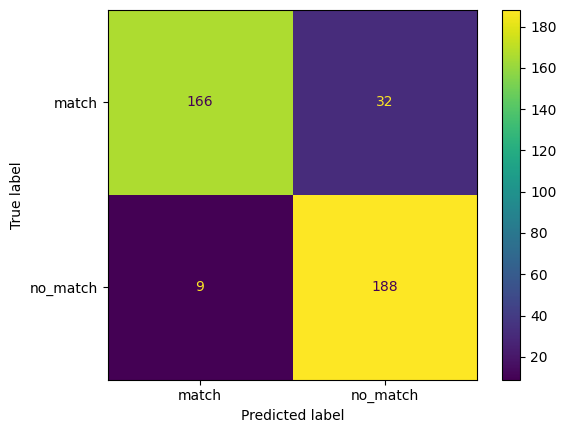

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import precision_recall_fscore_support, ConfusionMatrixDisplay

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    train_ready["interaction_embedding"].tolist(),
    train_ready["label"].tolist(),
    test_size=0.2,
    random_state=42,
    shuffle=True,
    stratify=train_ready["label"].tolist(),
)

# Train model
clf = LogisticRegressionCV(
    cv=10,
    max_iter=1000,
    random_state=42,
    # class_weight="balanced",
).fit(X_train, y_train)

# Evaluate model
y_pred = clf.predict(X_test)
precision, recall, f1, _ = precision_recall_fscore_support(
    y_test,
    y_pred,
    average="binary",
    pos_label="match",
)

# Print results
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")

# Plot confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

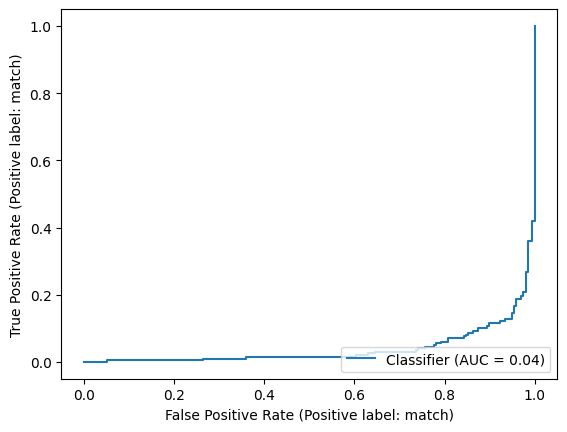

In [16]:
from sklearn.metrics import RocCurveDisplay

y_pred_conf = clf.decision_function(X_test)
RocCurveDisplay.from_predictions(y_test, y_pred_conf, pos_label="match")